In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.sparse as sps

import cupy as cp
from cupyx.scipy.ndimage import gaussian_filter
from cupyx.scipy.sparse.linalg import LinearOperator
from cupyx.scipy.sparse.linalg import cg as scipy_cg
from cupyx.scipy.sparse.linalg import aslinearoperator
from cupyx.scipy.sparse import coo_matrix as cupy_coo_matrix

from scipy.optimize import minimize

from gpcg import GPCGSolver
from gpcg import make_1d_signal, make_shepp_logan_image, build_1d_first_order_grad, build_2d_first_order_grad

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Example 1: deblurring with nonnegativity constraint (1D)

In [2]:
# Parameters for the problem
n = 100
reg_lambda = 1e2
blur_sigma = 1.5
noise_sigma = 0.2

# Make test signal
dom = np.linspace(0, 1, 100)
x = make_1d_signal( dom ) + np.sin(5*dom)

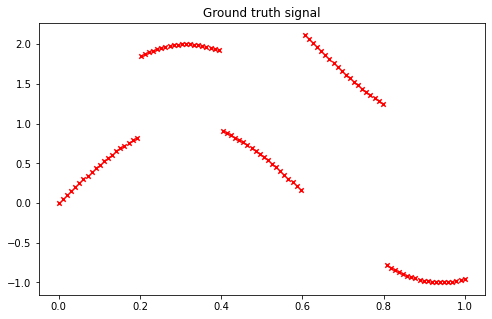

In [3]:
plt.figure(figsize=(8,5))
plt.scatter(dom, x, marker="x", color="red", s=20.0)
plt.title("Ground truth signal")
plt.show()

In [4]:
# Setup measurement and regularization operators
_matvec = lambda x: gaussian_filter(x, sigma=float(blur_sigma), mode="wrap")
F = LinearOperator((n,n), matvec=_matvec, rmatvec=_matvec)

# Build \lambda R operator
rmat = build_1d_first_order_grad(n, boundary="zero")
rmat = cupy_coo_matrix(rmat)
R = aslinearoperator(rmat)

# Build Q operator (plays role of A)
Q = (1.0/(noise_sigma**2))*(F.T @ F) + reg_lambda*(R.T @ R)

In [5]:
# Create some artificial data
np.random.seed(0)
y = F.matvec(cp.asarray(x)) + noise_sigma*cp.random.randn(n)

# Get solution via standard cg
scipy_cg_sol, _ = scipy_cg(Q, (1.0/(noise_sigma**2))*F.rmatvec(y) , maxiter=1e5)

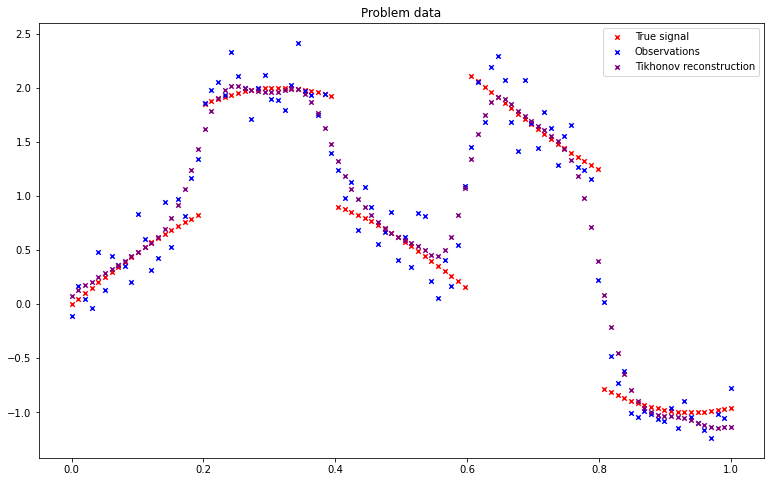

In [6]:
plt.figure(figsize=(13,8))
plt.scatter(dom, x, marker="x", color="red", s=20.0, label="True signal")
plt.scatter(dom, y.get(), marker="x", color="blue", s=20.0, label="Observations")
plt.scatter(dom, scipy_cg_sol.get(), marker="x", color="purple", s=20.0, label="Tikhonov reconstruction")
plt.legend()
plt.title("Problem data")
plt.show()

In [7]:
# Solve problem with gpcg
lower_bounds = cp.zeros(Q.shape[0])
upper_bounds = cp.inf*cp.ones(Q.shape[0])
solver = GPCGSolver(Q, (1.0/(noise_sigma**2))*F.rmatvec(y), lower_bounds=lower_bounds, upper_bounds=upper_bounds)
gpcg_solution = solver.solve(maxits=100, tol=1e-4)
print("Converged?" + " " + str(gpcg_solution["converged"]) )

Converged? True


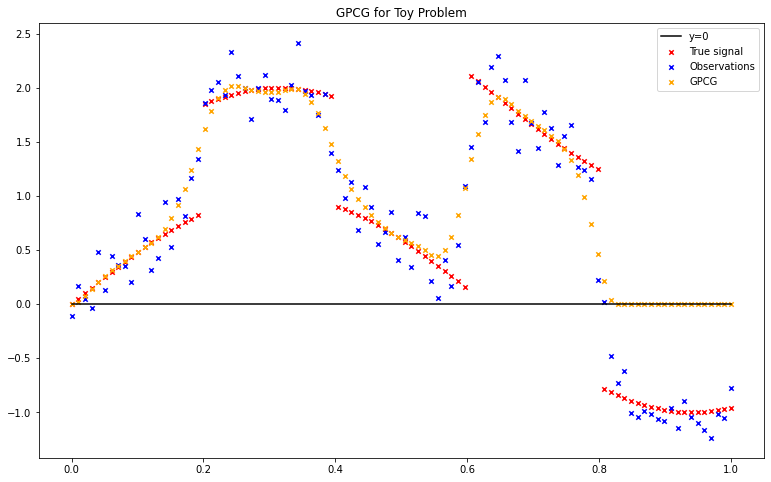

In [8]:
plt.figure(figsize=(13,8))
plt.scatter(dom, x, marker="x", color="red", s=20.0, label="True signal")
plt.scatter(dom, y.get(), marker="x", color="blue", s=20.0, label="Observations")
plt.scatter(dom, gpcg_solution["x"].get(), marker="x", color="orange", s=20.0, label="GPCG")
plt.plot(np.linspace(0, 1, 100), 0*np.linspace(0, 1, 100), label="y=0", color="black" )
plt.legend()
plt.title("GPCG for Toy Problem")
plt.show()

# Example 2: deblurring with nonnegativity constraint (2D)

In [9]:
# Problem parameters
resolution = 300
blur_sigma = 5
reg_lambda = 1e2
noise_sigma = 0.1

In [10]:
# Makes a test image
truth_img = make_shepp_logan_image(resolution)
M, N = truth_img.shape

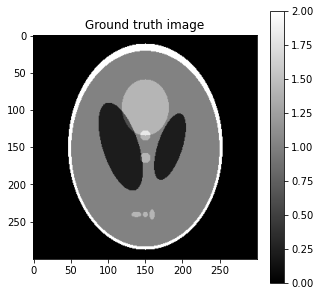

In [11]:
plt.figure(figsize=(5,5))
plt.imshow(truth_img, cmap="gray")
plt.title("Ground truth image")
plt.colorbar()
plt.show()

In [12]:
# Setup measurement and regularization operators
def build_blur_op(img_shape, blur_sigma):

    def _matvec(x):
        return gaussian_filter(x.reshape(img_shape), sigma=float(blur_sigma), mode="wrap").flatten()

    size = math.prod(img_shape)

    F = LinearOperator((size,size), matvec=_matvec, rmatvec=_matvec)

    return F

F = build_blur_op(truth_img.shape, blur_sigma)

# Build \lambda R operator
rmat = build_2d_first_order_grad(M, N, boundary="zero")
rmat = cupy_coo_matrix(rmat)
R = aslinearoperator(rmat)

# Build Q operator (plays role of A)
Q = (1.0/(noise_sigma**2))*(F.T @ F) + reg_lambda*(R.T @ R)

In [13]:
# Create a synthetic observation
img_shape = truth_img.shape
noisy_img = F.matvec( cp.asarray( truth_img.flatten() ) ).reshape(img_shape) + noise_sigma*cp.random.normal(size=img_shape)
noisy_img_flat = noisy_img.flatten()

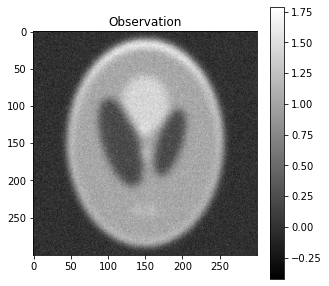

In [14]:
plt.figure(figsize=(5,5))
plt.imshow(noisy_img.get(), cmap="gray")
plt.title("Observation")
plt.colorbar()
plt.show()

In [15]:
# Get solution to unconstrained problem via standard cg
scipy_cg_sol, _ = scipy_cg(Q, (1.0/(noise_sigma**2))*F.rmatvec( noisy_img_flat ), maxiter=1e5)

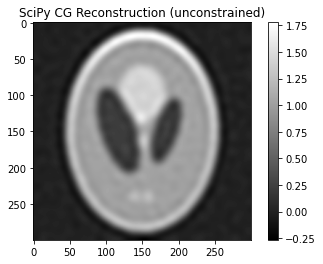

In [16]:
plt.imshow(scipy_cg_sol.reshape(img_shape).get(), cmap="gray")
plt.title("SciPy CG Reconstruction (unconstrained)")
plt.colorbar()
plt.show()

In [17]:
# Solve problem with gpcg
lower_bounds = cp.zeros(Q.shape[0])
upper_bounds = cp.inf*cp.ones(Q.shape[0])
solver = GPCGSolver(Q, (1.0/(noise_sigma**2))*F.rmatvec( noisy_img_flat ), lower_bounds=lower_bounds, upper_bounds=upper_bounds)
gpcg_solution = solver.solve(maxits=100, tol=1e-4)
print("Converged?" + " " + str(gpcg_solution["converged"]) )

Converged? True


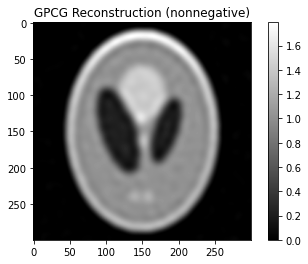

In [18]:
plt.imshow(gpcg_solution["x"].reshape(img_shape).get(), cmap="gray")
plt.title("GPCG Reconstruction (nonnegative)")
plt.colorbar()
plt.show()